# Predictive Analysis of Hotel Booking Data

## Data Loading

In [ ]:
!pip uninstall statsmodels

Found existing installation: statsmodels 0.13.1
Uninstalling statsmodels-0.13.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/statsmodels-0.13.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/statsmodels/*
Proceed (y/n)? y
  Successfully uninstalled statsmodels-0.13.1


In [ ]:
!pip install numpy scipy patsy pandas

In [ ]:
!pip install statsmodels

  Using cached statsmodels-0.13.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)


In [ ]:
!pip install pmdarima
import numpy as np
import pandas as pd
import seaborn as sn
from typing import List
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss,f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [ ]:
pwd

'/content'

In [ ]:
data=pd.read_csv("hotel_bookings.csv")

## EDA

In [ ]:
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [ ]:
data.country.unique()

array(['PRT', 'GBR', 'USA', 'ESP', 'IRL', 'FRA', nan, 'ROU', 'NOR', 'OMN',
       'ARG', 'POL', 'DEU', 'BEL', 'CHE', 'CN', 'GRC', 'ITA', 'NLD',
       'DNK', 'RUS', 'SWE', 'AUS', 'EST', 'CZE', 'BRA', 'FIN', 'MOZ',
       'BWA', 'LUX', 'SVN', 'ALB', 'IND', 'CHN', 'MEX', 'MAR', 'UKR',
       'SMR', 'LVA', 'PRI', 'SRB', 'CHL', 'AUT', 'BLR', 'LTU', 'TUR',
       'ZAF', 'AGO', 'ISR', 'CYM', 'ZMB', 'CPV', 'ZWE', 'DZA', 'KOR',
       'CRI', 'HUN', 'ARE', 'TUN', 'JAM', 'HRV', 'HKG', 'IRN', 'GEO',
       'AND', 'GIB', 'URY', 'JEY', 'CAF', 'CYP', 'COL', 'GGY', 'KWT',
       'NGA', 'MDV', 'VEN', 'SVK', 'FJI', 'KAZ', 'PAK', 'IDN', 'LBN',
       'PHL', 'SEN', 'SYC', 'AZE', 'BHR', 'NZL', 'THA', 'DOM', 'MKD',
       'MYS', 'ARM', 'JPN', 'LKA', 'CUB', 'CMR', 'BIH', 'MUS', 'COM',
       'SUR', 'UGA', 'BGR', 'CIV', 'JOR', 'SYR', 'SGP', 'BDI', 'SAU',
       'VNM', 'PLW', 'QAT', 'EGY', 'PER', 'MLT', 'MWI', 'ECU', 'MDG',
       'ISL', 'UZB', 'NPL', 'BHS', 'MAC', 'TGO', 'TWN', 'DJI', 'STP',
       'KNA', 'E

In [ ]:
data.country.value_counts()

PRT    48590
GBR    12129
FRA    10415
ESP     8568
DEU     7287
       ...  
LCA        1
NPL        1
ASM        1
NIC        1
PLW        1
Name: country, Length: 177, dtype: int64

In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [ ]:
def missing_value_counter(df:pd.DataFrame, cols:List[str]) -> pd.DataFrame:
    """
    Count missing values in specified columns.
    @param df: dataframe
    @param cols: columns to be calculated
    return: summary information
    """
    res = pd.DataFrame(cols, columns=['Feature'])
    na_cnts = [sum(df[col].isna()) for col in cols]
    res['NA Count'] = na_cnts
    res['NA Rate'] = res['NA Count'] / df.shape[0]
    res = res[res['NA Count'] != 0]
    res = res.sort_values(by='NA Count', ascending=False).reset_index(drop=True)
    return res

In [ ]:
def value_counter(df:pd.DataFrame, cols:List[str], val:float) -> pd.DataFrame:
    """
    Count specified values in specified columns.
    @param df: dataframe
    @param cols: columns to be calculated
    return: summary information
    """
    res = pd.DataFrame(cols, columns=['Feature'])
    na_cnts = [sum(df[col] == val) for col in cols]
    res['Value Count'] = na_cnts
    res['Rate'] = res['Value Count'] / df.shape[0]
    res = res[res['Value Count'] != 0]
    res = res.sort_values(by='Value Count', ascending=False).reset_index(drop=True)
    return res

In [ ]:
missing_value_counter(data, data.columns)

,Feature,NA Count,NA Rate
0,company,112593,0.943069
1,agent,16340,0.136862
2,country,488,0.004087
3,children,4,0.000034


In [ ]:
value_counter(data, data.columns, 0)

,Feature,Value Count,Rate
0,babies,118473,0.992319
1,previous_bookings_not_canceled,115770,0.969679
2,days_in_waiting_list,115692,0.969026
3,is_repeated_guest,115580,0.968088
4,previous_cancellations,112906,0.945691
5,required_car_parking_spaces,111974,0.937884
6,children,110796,0.928017
7,booking_changes,101314,0.848597
8,is_canceled,75166,0.629584
9,total_of_special_requests,70318,0.588977


In [ ]:
# data=data.drop(['company','agent'],axis=1)
data['country'].dropna(inplace=True)


In [ ]:
data.fillna(0,inplace=True)

In [ ]:
datetime_object = data['arrival_date_month'].str[0:3]
month_number = np.zeros(len(datetime_object))

# Creating a new column based on numerical representation of the months
for i in range(0, len(datetime_object)):
    datetime_object[i] = datetime.datetime.strptime(datetime_object[i], "%b")
    month_number[i] = datetime_object[i].month

# Float to integer conversion
month_number = pd.DataFrame(month_number).astype(int)

In [ ]:
data['arrival_date'] = data['arrival_date_year'].map(str) + '-' + month_number[0].map(str) + '-' \
                       + data['arrival_date_day_of_month'].map(str)

In [ ]:
data['children'] = data['children'].astype(int)

In [ ]:
# data = data.drop(['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month',
#                   'arrival_date_week_number'], axis=1)
# data.head()

In [ ]:
data['arrival_date'] = pd.to_datetime(data['arrival_date'])
data['reservation_status_date'] = pd.to_datetime(data['reservation_status_date'])


In [ ]:
data['Total Guests'] = data['adults'] + data['children']
data = data[data['Total Guests'] != 0]

In [ ]:
data['Total_Stays'] = data['stays_in_weekend_nights'] + data['stays_in_week_nights']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
fig = px.histogram(data,x='is_canceled',
                        title='Number of Bookings: (Cancelled-1 & Confirmed-0)',
                        color = 'is_canceled',
                        labels={'is_canceled':'Booking Type'}
                        )
fig.update_layout(barmode='group',height=400,width=600,yaxis_title='Number of Bookings')
fig.update_xaxes(type='category')
fig.show()


In [ ]:
from plotly.subplots import make_subplots
df_booked = data[data['is_canceled'] ==0]
df_cancelled = data[data['is_canceled']==1]
hotel_book_per = df_booked.hotel[df_booked['hotel'] == 'City Hotel'].count()/data.hotel[data['hotel']=='City Hotel'].count() * 100
resort_book_per = df_booked.hotel[df_booked['hotel'] == 'Resort Hotel'].count()/data.hotel[data['hotel']=='Resort Hotel'].count() * 100

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=["Booked Hotel","Canceled Hotel"], values=[hotel_book_per,100-hotel_book_per]),1, 1)
fig.add_trace(go.Pie(labels=["Booked Resorts","Canceled Resorts"], values=[resort_book_per,100-resort_book_per]),1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent")

fig.update_layout(height = 520 ,width=1000,template='plotly_dark',
    title_text="Confirmed & Cancelled Bookings % by Hotels and Resorts",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Hotel', x=0.18, y=0.5, font_size=20, showarrow=False),
                 dict(text='Resort', x=0.82, y=0.5, font_size=20, showarrow=False)])
fig.show()

In [ ]:
#from plotly.subplots import make_subplots
#df_booked = data[data['is_canceled'] ==0]
#df_cancelled = data[data['is_canceled']==1]
#hotel_book_per = df_booked.hotel[df_booked['hotel'] == 'City Hotel'].count()/data.hotel[data['hotel']=='City Hotel'].count() * 100
#resort_book_per = df_booked.hotel[df_booked['hotel'] == 'Resort Hotel'].count()/data.hotel[data['hotel']=='Resort Hotel'].count() * 100

#plt.figure(figsize=(12,8))

hotel_book_per                  
                        


58.214064651415434

In [ ]:
fig = go.Figure()
fig.add_trace(go.Pie(labels=df_cancelled.customer_type.unique(),values=df_cancelled.customer_type.value_counts(),name='Cancel'))
fig.update_layout(height = 400 ,width=720,title_text='Cancelled Bookings: by Customer Types')
fig.show()

In [ ]:
fig = px.pie(df_booked,names=df_booked.customer_type.unique(),values=df_booked.customer_type.value_counts())
fig.update_layout(height = 400 ,width=720,template='plotly_dark',title_text='Confirmed Bookings:by Customer Types')
fig.show()

In [ ]:
country_freq = data['country'].value_counts().to_frame()
country_freq.columns = ['count']
fig = px.choropleth(country_freq, color='count',
                    locations=country_freq.index,
                    hover_name=country_freq.index,
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.update_traces(marker=dict(line=dict(color='#000000', width=1)))
fig.update_layout(title_text='Number of Records by Countries',
                  title_x=0.5, title_font=dict(size=22))  # Location and the font size of the main title
fig.show()

In [ ]:
# How much do guests pay for a room per night?
# Both hotels have different room types and different meal arrangements. Seasonal factors are also important. So the prices vary a lot.
# Since no currency information is given, but Portugal is part of the European Monetary Union, I assume that all prices are in EUR.
# After cleaning, separate Resort and City hotel
# To know the acutal visitor numbers, only bookings that were not canceled are included. 
rh = data.loc[(data["hotel"] == "Resort Hotel") & (data["is_canceled"] == 0)]
ch = data.loc[(data["hotel"] == "City Hotel") & (data["is_canceled"] == 0)]

In [ ]:
# Counting adults and children as paying guests only, not babies.
rh["adr_pp"] = rh["adr"] / (rh["adults"] + rh["children"])
ch["adr_pp"] = ch["adr"] / (ch["adults"] + ch["children"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
print("""From all non-cnceled bookings, across all room types and meals, the average prices are:
Resort hotel: {:.2f} € per night and person.
City hotel: {:.2f} € per night and person."""
      .format(rh["adr_pp"].mean(), ch["adr_pp"].mean()))

From all non-cnceled bookings, across all room types and meals, the average prices are:
Resort hotel: 47.49 € per night and person.
City hotel: 59.27 € per night and person.


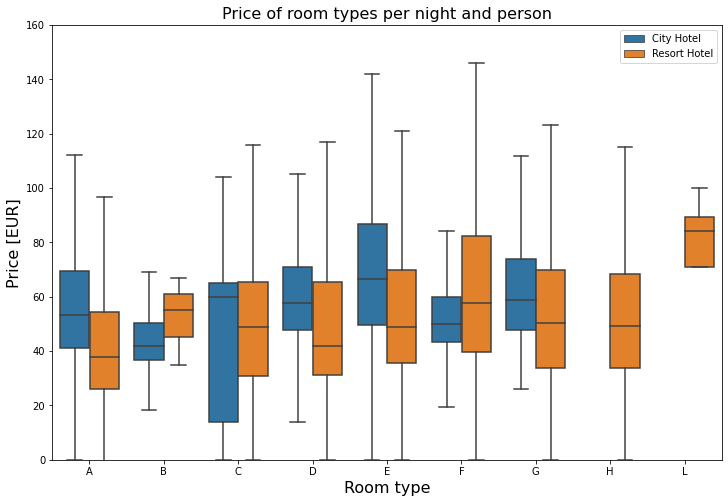

In [ ]:
# normalize price per night (adr):
data["adr_pp"] = data["adr"] / (data["adults"] + data["children"])
full_data_guests = data.loc[data["is_canceled"] == 0] # only actual gusts
room_prices = full_data_guests[["hotel", "reserved_room_type", "adr_pp"]].sort_values("reserved_room_type")

# boxplot:
plt.figure(figsize=(12, 8))
sn.boxplot(x="reserved_room_type",
            y="adr_pp",
            hue="hotel",
            data=room_prices, 
            hue_order=["City Hotel", "Resort Hotel"],
            fliersize=0)
plt.title("Price of room types per night and person", fontsize=16)
plt.xlabel("Room type", fontsize=16)
plt.ylabel("Price [EUR]", fontsize=16)
plt.legend(loc="upper right")
plt.ylim(0, 160)
plt.show()

This figure shows the average price per room, depending on its type and the standard deviation.
Note that due to data anonymization rooms with the same type letter may not necessarily be the same across hotels.

How does the price per night vary over the year?
To keep it simple, I'm using the average price per night and person, regardless of the room type and meal.

In [ ]:
full_data_guests

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,Total Guests,Total_Stays,adr_pp
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0.0,0.0,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01,2,0,0.000000
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0.0,0.0,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01,2,0,0.000000
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.0,0.0,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01,1,1,75.000000
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0.0,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01,1,1,75.000000
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0.0,0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-07-01,2,2,49.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,0.0,0,Transient,96.14,0,0,Check-Out,2017-09-06,2017-08-30,2,7,48.070000
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,0.0,0,Transient,225.43,0,2,Check-Out,2017-09-07,2017-08-31,3,7,75.143333
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,0.0,0,Transient,157.71,0,4,Check-Out,2017-09-07,2017-08-31,2,7,78.855000
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,0.0,0,Transient,104.40,0,0,Check-Out,2017-09-07,2017-08-31,2,7,52.200000


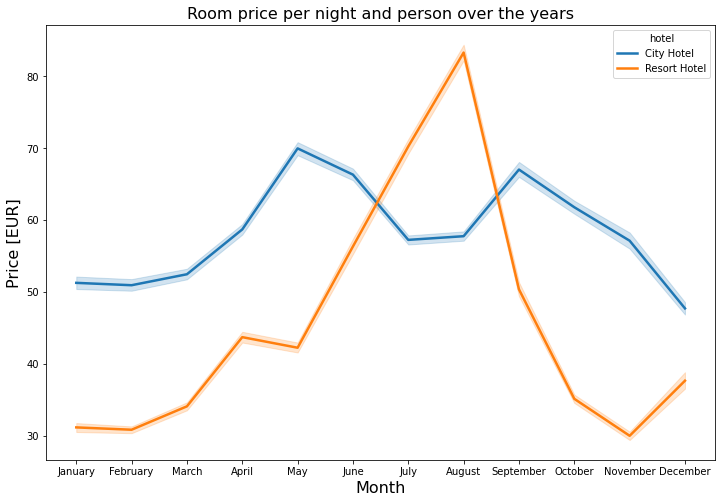

In [ ]:
# grab data:
room_prices_mothly = full_data_guests[["hotel", "arrival_date_month", "adr_pp"]].sort_values("arrival_date_month")

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
room_prices_mothly["arrival_date_month"] = pd.Categorical(room_prices_mothly["arrival_date_month"], categories=ordered_months, ordered=True)

# barplot with standard deviation:
plt.figure(figsize=(12, 8))
sn.lineplot(x = "arrival_date_month", y="adr_pp", hue="hotel", data=room_prices_mothly, 
            hue_order = ["City Hotel", "Resort Hotel"], size="hotel", sizes=(2.5, 2.5))
plt.title("Room price per night and person over the years", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=360)
plt.ylabel("Price [EUR]", fontsize=16)
plt.show()

This clearly shows that the prices in the Resort hotel are much higher during the summer (no surprise here).
The price of the city hotel varies less and is most expensive during spring and autumn.

Which are the most busy month?

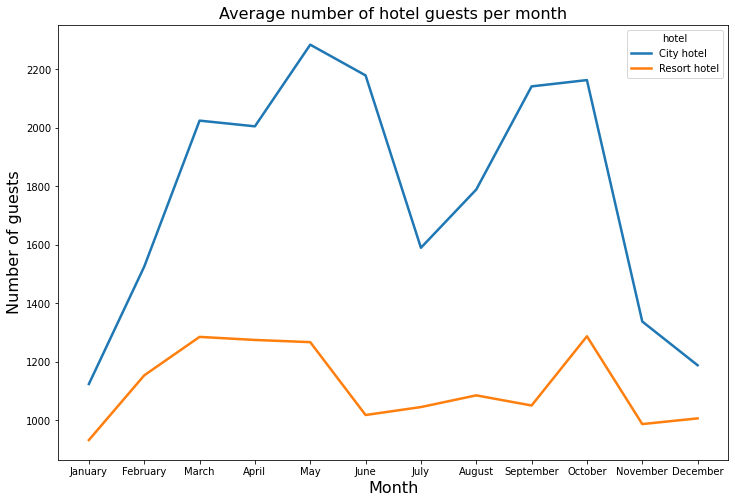

In [ ]:
# Create a DateFrame with the relevant data:
resort_guests_monthly = rh.groupby("arrival_date_month")["hotel"].count()
city_guests_monthly = ch.groupby("arrival_date_month")["hotel"].count()

resort_guest_data = pd.DataFrame({"month": list(resort_guests_monthly.index),
                    "hotel": "Resort hotel", 
                    "guests": list(resort_guests_monthly.values)})

city_guest_data = pd.DataFrame({"month": list(city_guests_monthly.index),
                    "hotel": "City hotel", 
                    "guests": list(city_guests_monthly.values)})
full_guest_data = pd.concat([resort_guest_data,city_guest_data], ignore_index=True)

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_guest_data["month"] = pd.Categorical(full_guest_data["month"], categories=ordered_months, ordered=True)

# Dataset contains July and August date from 3 years, the other month from 2 years. Normalize data:
full_guest_data.loc[(full_guest_data["month"] == "July") | (full_guest_data["month"] == "August"),
                    "guests"] /= 3
full_guest_data.loc[~((full_guest_data["month"] == "July") | (full_guest_data["month"] == "August")),
                    "guests"] /= 2

#show figure:
plt.figure(figsize=(12, 8))
sn.lineplot(x = "month", y="guests", hue="hotel", data=full_guest_data, 
             hue_order = ["City hotel", "Resort hotel"], size="hotel", sizes=(2.5, 2.5))
plt.title("Average number of hotel guests per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=360)
plt.ylabel("Number of guests", fontsize=16)
plt.show()

The City hotel has more guests during spring and autumn, when the prices are also highest.
In July and August there are less visitors, although prices are lower.

Guest numbers for the Resort hotel go down slighty from June to September, which is also when the prices are highest.
Both hotels have the fewest guests during the winter.

How long do people stay at the hotels?

In [ ]:
# Create a DateFrame with the relevant data:
rh["total_nights"] = rh["stays_in_weekend_nights"] + rh["stays_in_week_nights"]
ch["total_nights"] = ch["stays_in_weekend_nights"] + ch["stays_in_week_nights"]

num_nights_res = list(rh["total_nights"].value_counts().index)
num_bookings_res = list(rh["total_nights"].value_counts())
rel_bookings_res = rh["total_nights"].value_counts() / sum(num_bookings_res) * 100 # convert to percent

num_nights_cty = list(ch["total_nights"].value_counts().index)
num_bookings_cty = list(ch["total_nights"].value_counts())
rel_bookings_cty = ch["total_nights"].value_counts() / sum(num_bookings_cty) * 100 # convert to percent

res_nights = pd.DataFrame({"hotel": "Resort hotel",
                           "num_nights": num_nights_res,
                           "rel_num_bookings": rel_bookings_res})

cty_nights = pd.DataFrame({"hotel": "City hotel",
                           "num_nights": num_nights_cty,
                           "rel_num_bookings": rel_bookings_cty})

nights_data = pd.concat([res_nights, cty_nights], ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



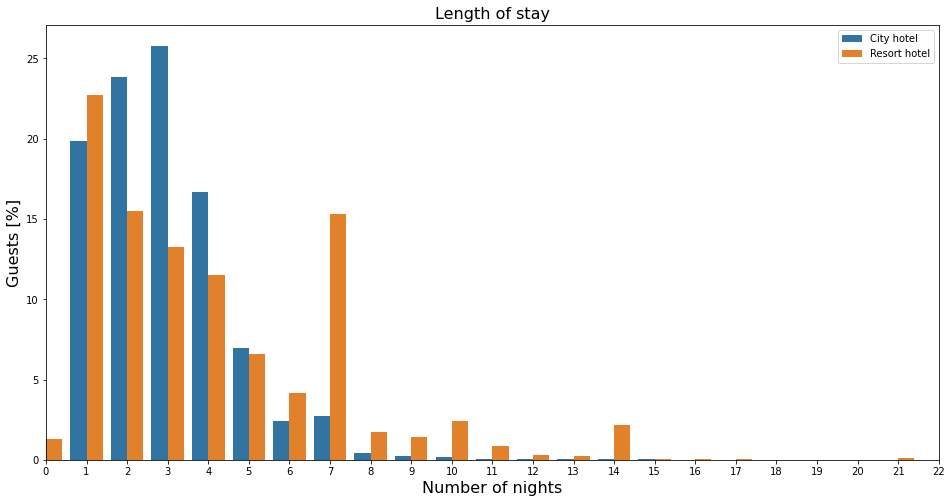

In [ ]:
#show figure:
plt.figure(figsize=(16, 8))
sn.barplot(x = "num_nights", y = "rel_num_bookings", hue="hotel", data=nights_data,
            hue_order = ["City hotel", "Resort hotel"])
plt.title("Length of stay", fontsize=16)
plt.xlabel("Number of nights", fontsize=16)
plt.ylabel("Guests [%]", fontsize=16)
plt.legend(loc="upper right")
plt.xlim(0,22)
plt.show()

For the city hotel there is a clear preference for 1-4 nights.
For the resort hotel, 1-4 nights are also often booked, but 7 nights also stand out as being very popular.

Bookings by market segment

In [ ]:
# total bookings per market segment (incl. canceled)
segments=data["market_segment"].value_counts()

# pie plot
fig = px.pie(segments,
             values=segments.values,
             names=segments.index,
             title="Bookings per market segment",
             template="seaborn")
fig.update_traces(rotation=-90, textinfo="percent+label")
fig.show()

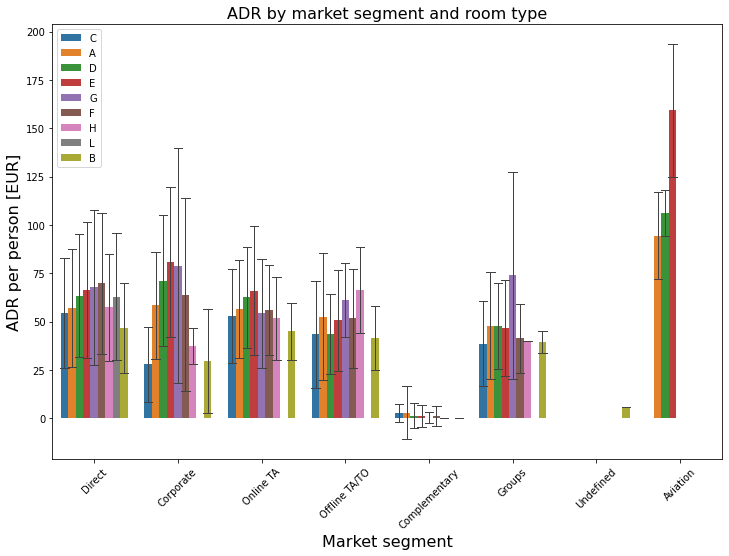

In [ ]:
# price per night (ADR) and person based on booking and room.
# show figure:
plt.figure(figsize=(12, 8))
sn.barplot(x="market_segment",
            y="adr_pp",
            hue="reserved_room_type",
            data=data,
            ci="sd",
            errwidth=1,
            capsize=0.1)
plt.title("ADR by market segment and room type", fontsize=16)
plt.xlabel("Market segment", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("ADR per person [EUR]", fontsize=16)
plt.legend(loc="upper left")
plt.show()

On average, groups get the best prices and Airlines pay approximately twice as much.

What are possible reasons for the high prices paid by Airlines?

In [ ]:
# Summarize Relevant data:
Airline_data = data.loc[data["market_segment"]== "Aviation"][["is_canceled",
                                                                                "adults",
                                                                                "lead_time",
                                                                                "adr_pp",]].describe()

Non_Airline_data = data.loc[data["market_segment"]!= "Aviation"][["is_canceled","adults","lead_time",
                 "adr_pp",]].describe()
Airline_data

,is_canceled,adults,lead_time,adr_pp
count,235.000000,235.000000,235.00000,235.000000
mean,0.221277,1.012766,4.47234,100.270979
std,0.415992,0.112503,4.61629,20.376689
min,0.000000,1.000000,0.00000,0.000000
25%,0.000000,1.000000,1.00000,95.000000
50%,0.000000,1.000000,3.00000,95.000000
75%,0.000000,1.000000,6.00000,110.000000
max,1.000000,2.000000,23.00000,193.500000


In [ ]:
Non_Airline_data

,is_canceled,adults,lead_time,adr_pp
count,118975.000000,118975.000000,118975.000000,118975.000000
mean,0.371061,1.860878,104.306031,55.036835
std,0.483091,0.574499,106.888885,29.017596
min,0.000000,0.000000,0.000000,-3.190000
25%,0.000000,2.000000,18.000000,37.440000
50%,0.000000,2.000000,69.000000,49.500000
75%,1.000000,2.000000,161.000000,66.000000
max,1.000000,55.000000,737.000000,2700.000000


Lead time for bookings from Aviation is very short: Mean 4 days vs. 104 days for other bookings.
Airlines NEED a place for their crews to stay.
Airline personel usually gets one room per person - more total rooms required compared to families.

How many bookings were canceled?


In [ ]:
# absolute cancelations:
total_cancelations = data["is_canceled"].sum()
rh_cancelations = data.loc[data["hotel"] == "Resort Hotel"]["is_canceled"].sum()
ch_cancelations = data.loc[data["hotel"] == "City Hotel"]["is_canceled"].sum()

# as percent:
rel_cancel = total_cancelations / data.shape[0] * 100
rh_rel_cancel = rh_cancelations / data.loc[data["hotel"] == "Resort Hotel"].shape[0] * 100
ch_rel_cancel = ch_cancelations / data.loc[data["hotel"] == "City Hotel"].shape[0] * 100

print(f"Total bookings canceled: {total_cancelations:,} ({rel_cancel:.0f} %)")
print(f"Resort hotel bookings canceled: {rh_cancelations:,} ({rh_rel_cancel:.0f} %)")
print(f"City hotel bookings canceled: {ch_cancelations:,} ({ch_rel_cancel:.0f} %)")

Total bookings canceled: 44,199 (37 %)
Resort hotel bookings canceled: 11,120 (28 %)
City hotel bookings canceled: 33,079 (42 %)


Which month have the highest number of cancelations?

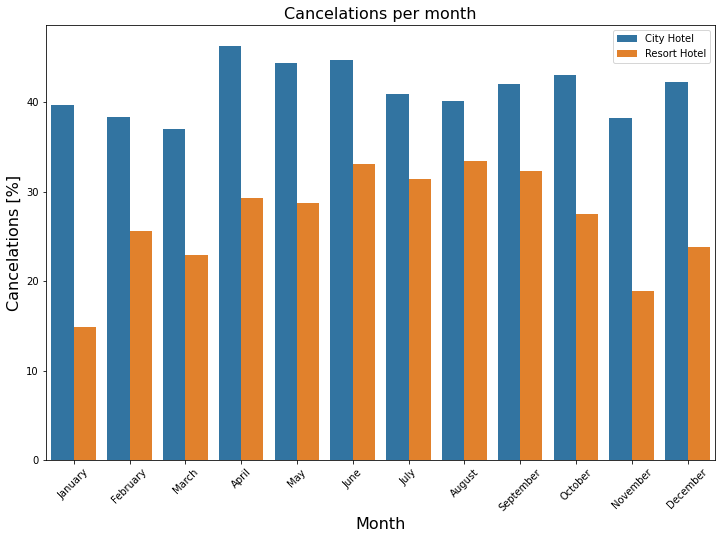

In [ ]:
# Create a DateFrame with the relevant data:
res_book_per_month = data.loc[(data["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
res_cancel_per_month = data.loc[(data["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

cty_book_per_month = data.loc[(data["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
cty_cancel_per_month = data.loc[(data["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

res_cancel_data = pd.DataFrame({"Hotel": "Resort Hotel",
                                "Month": list(res_book_per_month.index),
                                "Bookings": list(res_book_per_month.values),
                                "Cancelations": list(res_cancel_per_month.values)})
cty_cancel_data = pd.DataFrame({"Hotel": "City Hotel",
                                "Month": list(cty_book_per_month.index),
                                "Bookings": list(cty_book_per_month.values),
                                "Cancelations": list(cty_cancel_per_month.values)})

full_cancel_data = pd.concat([res_cancel_data, cty_cancel_data], ignore_index=True)
full_cancel_data["cancel_percent"] = full_cancel_data["Cancelations"] / full_cancel_data["Bookings"] * 100

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories=ordered_months, ordered=True)

# show figure:
plt.figure(figsize=(12, 8))
sn.barplot(x = "Month", y = "cancel_percent" , hue="Hotel",
            hue_order = ["City Hotel", "Resort Hotel"], data=full_cancel_data)
plt.title("Cancelations per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.legend(loc="upper right")
plt.show()

For the City hotel the relative number of cancelations is around 40 % throughout the year.
For the Resort hotel it is highest in the summer and lowest during the winter.

In [ ]:
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,Total Guests,Total_Stays,adr_pp
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0.0,0.0,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,2,0,0.0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0.0,0.0,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,2,0,0.0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.0,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,1,1,75.0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,1,1,75.0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01,2,2,49.0


In [ ]:
top5_countries = data['country'].value_counts()[0:5]

top5_countries

PRT    48483
GBR    12120
FRA    10401
ESP     8560
DEU     7285
Name: country, dtype: int64

Text(0.5, 1.0, 'Top 5 Countries with highest number of bookings')

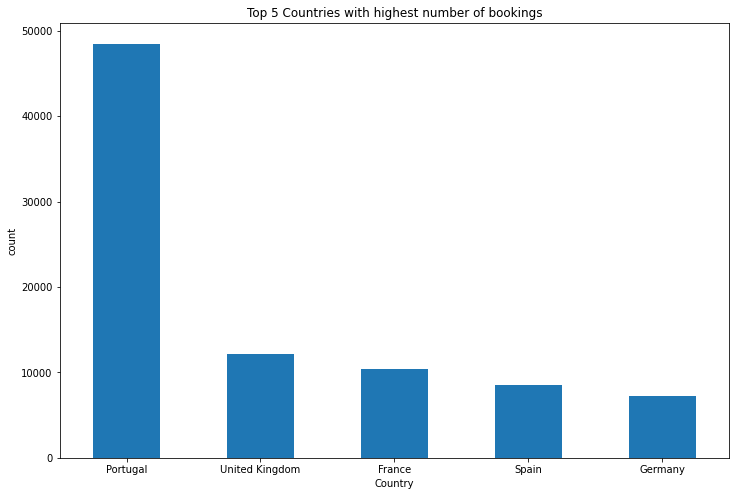

In [ ]:
ticks=[0,1,2,3,4]
cty=["Portugal","United Kingdom", "France","Spain","Germany"]

plt.figure(figsize=(12,8))
top5_countries.plot.bar()
plt.xlabel("Country")
plt.ylabel("count")
plt.xticks(rotation=360, horizontalalignment="center")
plt.xticks(ticks,cty)
plt.title("Top 5 Countries with highest number of bookings")


Portugal,United Kingdom of Great Britain and Northern Ireland, France,Spain and Germany rank to be the top 5 countries with highest bookings. So we can say that Europe is a popular tourist place. Much expected. 

In [ ]:
countries_cancellation = data[["hotel","country","reservation_status"]]

countries_cancellation=countries_cancellation.loc[countries_cancellation["reservation_status"]=='Canceled']

countries_cancellation

,hotel,country,reservation_status
8,Resort Hotel,PRT,Canceled
9,Resort Hotel,PRT,Canceled
10,Resort Hotel,PRT,Canceled
27,Resort Hotel,PRT,Canceled
32,Resort Hotel,PRT,Canceled
...,...,...,...
107980,City Hotel,FRA,Canceled
107997,City Hotel,SWE,Canceled
108000,City Hotel,SWE,Canceled
111355,City Hotel,PRT,Canceled


In [ ]:
total_counts=countries_cancellation["country"].value_counts()

total_counts

PRT    26743
GBR     2412
ESP     2145
FRA     1901
ITA     1315
       ...  
UMI        1
SYC        1
CRI        1
ZMB        1
LIE        1
Name: country, Length: 128, dtype: int64

In [ ]:
# Made a copy of dataframe
data_subset = data.copy()


In [ ]:
#Created a new column called Room, value of room is 1 if the customer gets assigned with the room he/she reservered, elso it will be 0.
data_subset['Room'] = 0
data_subset.loc[ data_subset['reserved_room_type'] == data_subset['assigned_room_type'] , 'Room'] = 1


## Make the new column which contain 1 if the guest has cancelled more booking in the past
## than the number of booking he did not cancel, otherwise 0

data_subset['net_cancelled'] = 0
data_subset.loc[ data_subset['previous_cancellations'] > data_subset['previous_bookings_not_canceled'] , 'net_cancelled'] = 1


In [ ]:
data_subset = data_subset.drop(['arrival_date_year','arrival_date_week_number','arrival_date_day_of_month',
                            'arrival_date_month','assigned_room_type','reserved_room_type','reservation_status_date',
                            'previous_cancellations','previous_bookings_not_canceled', 'reservation_status'],axis=1)

LEAD TIME : Number of days that elapsed between the entering date of the booking into the PMS and the arrival date

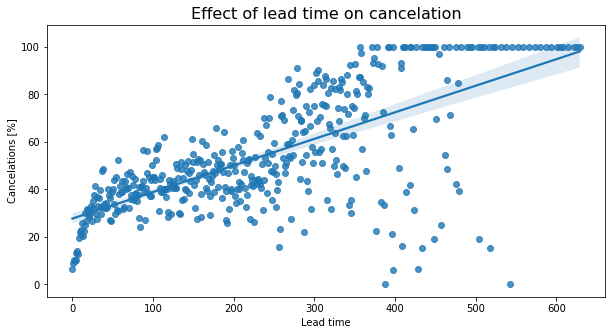

In [ ]:
# group data for lead_time:
lead_cancel_data = data_subset.groupby("lead_time")["is_canceled"].describe()

# use only lead_times with more than 10 bookings for graph:
lead_cancel_data_10 = lead_cancel_data.loc[lead_cancel_data["count"] >= 10]

#show figure:
plt.figure(figsize=(10,5))
sn.regplot(x=lead_cancel_data_10.index, y=lead_cancel_data_10["mean"].values * 100)
plt.title("Effect of lead time on cancelation", fontsize=16)
plt.xlabel("Lead time",fontsize=10)
plt.ylabel("Cancelations [%]", fontsize=10)
# plt.xlim(0,365)
plt.show()

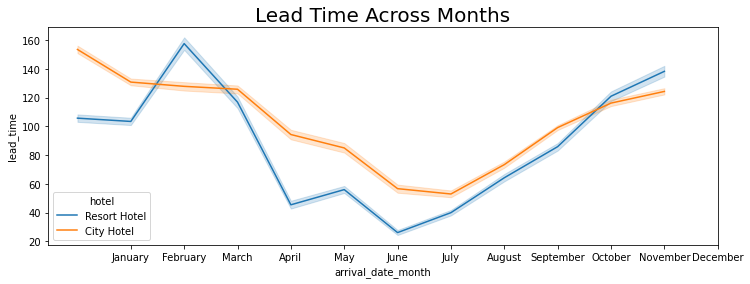

In [ ]:
# Next, I visualise the lead time for every month, since, from earlier observations that number of bookings increase during the summer months a similar pattern should be observed here as well.
labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
ticks = np.arange(1,13)
plt.figure(figsize=(12,4))
sn.lineplot(data=data, x='arrival_date_month', y='lead_time', hue='hotel')
plt.xticks(ticks=ticks, labels=labels)
plt.title("Lead Time Across Months", fontdict={'fontsize' : 20})
plt.show()

In [ ]:
data_subset

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,arrival_date,Total Guests,Total_Stays,adr_pp,Room,net_cancelled
0,Resort Hotel,0,342,0,0,2,0,0,BB,PRT,Direct,Direct,0,3,No Deposit,0.0,0.0,0,Transient,0.00,0,0,2015-07-01,2,0,0.000000,1,0
1,Resort Hotel,0,737,0,0,2,0,0,BB,PRT,Direct,Direct,0,4,No Deposit,0.0,0.0,0,Transient,0.00,0,0,2015-07-01,2,0,0.000000,1,0
2,Resort Hotel,0,7,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,No Deposit,0.0,0.0,0,Transient,75.00,0,0,2015-07-01,1,1,75.000000,0,0
3,Resort Hotel,0,13,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,No Deposit,304.0,0.0,0,Transient,75.00,0,0,2015-07-01,1,1,75.000000,1,0
4,Resort Hotel,0,14,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,No Deposit,240.0,0.0,0,Transient,98.00,0,1,2015-07-01,2,2,49.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2,5,2,0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,No Deposit,394.0,0.0,0,Transient,96.14,0,0,2017-08-30,2,7,48.070000,1,0
119386,City Hotel,0,102,2,5,3,0,0,BB,FRA,Online TA,TA/TO,0,0,No Deposit,9.0,0.0,0,Transient,225.43,0,2,2017-08-31,3,7,75.143333,1,0
119387,City Hotel,0,34,2,5,2,0,0,BB,DEU,Online TA,TA/TO,0,0,No Deposit,9.0,0.0,0,Transient,157.71,0,4,2017-08-31,2,7,78.855000,1,0
119388,City Hotel,0,109,2,5,2,0,0,BB,GBR,Online TA,TA/TO,0,0,No Deposit,89.0,0.0,0,Transient,104.40,0,0,2017-08-31,2,7,52.200000,1,0


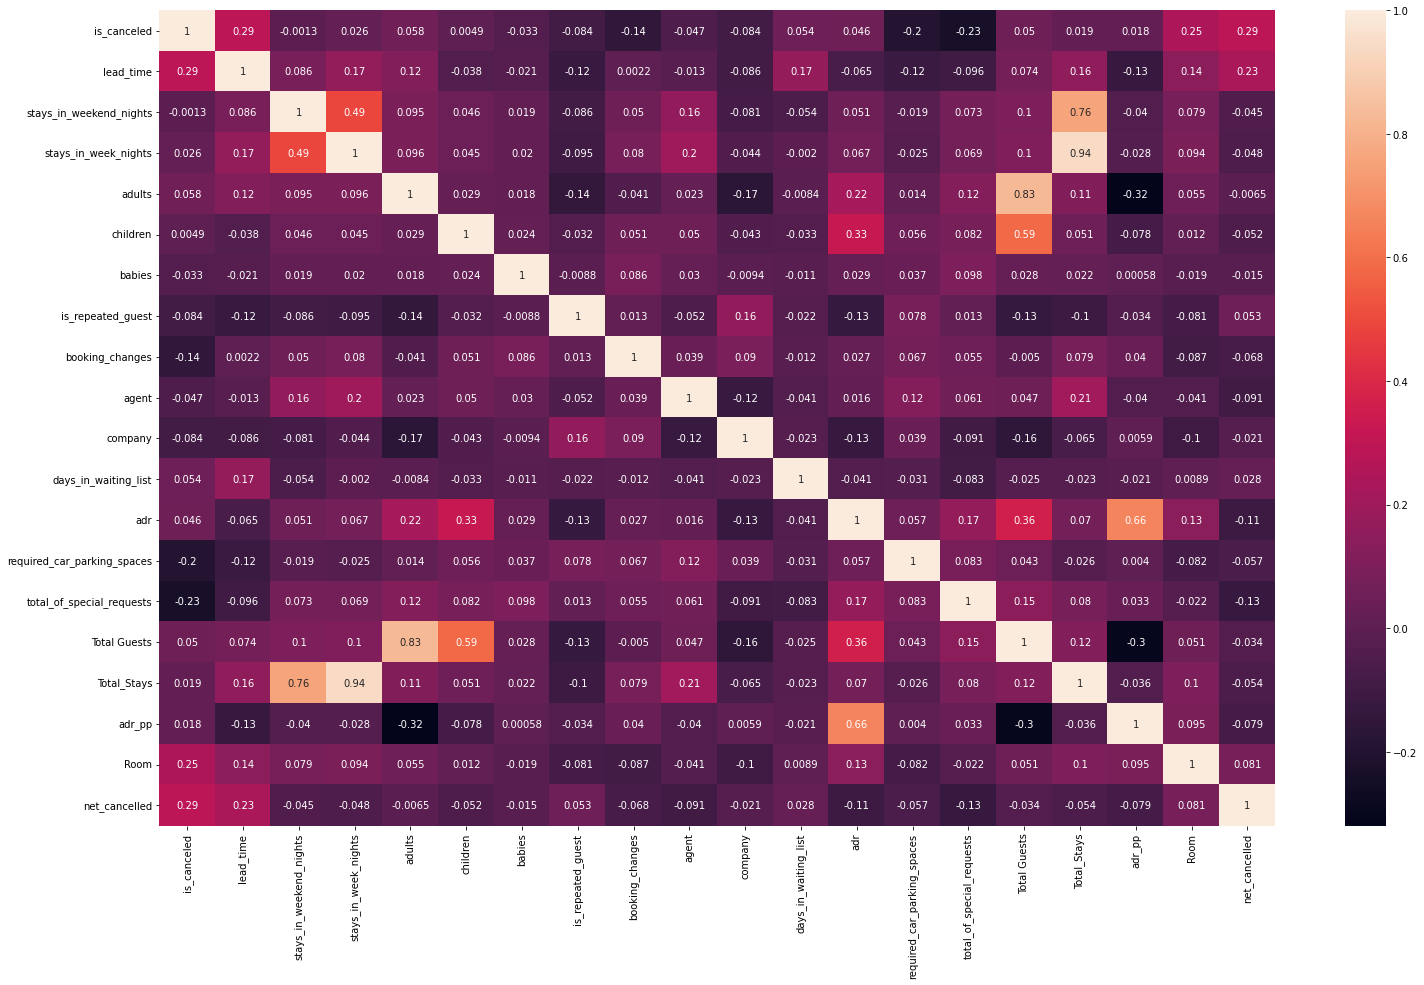

In [ ]:
## Plot the heatmap to see correlation with columns
fig, ax = plt.subplots(figsize=(25,15))
sn.heatmap(data_subset.corr(), annot=True, ax=ax);

We can see our features, lead_time, total special requests, Room and net_cancelled have a higher correlation with is_cancelled than most of the other columns.

In [ ]:
customer_cancellations = data[["hotel","customer_type","arrival_date_year","reservation_status"]]

customer_cancellations=customer_cancellations.loc[customer_cancellations["reservation_status"]=='Canceled']

customer_cancellations

,hotel,customer_type,arrival_date_year,reservation_status
8,Resort Hotel,Transient,2015,Canceled
9,Resort Hotel,Transient,2015,Canceled
10,Resort Hotel,Transient,2015,Canceled
27,Resort Hotel,Transient,2015,Canceled
32,Resort Hotel,Transient,2015,Canceled
...,...,...,...,...
107980,City Hotel,Transient,2017,Canceled
107997,City Hotel,Transient,2017,Canceled
108000,City Hotel,Transient,2017,Canceled
111355,City Hotel,Transient,2017,Canceled


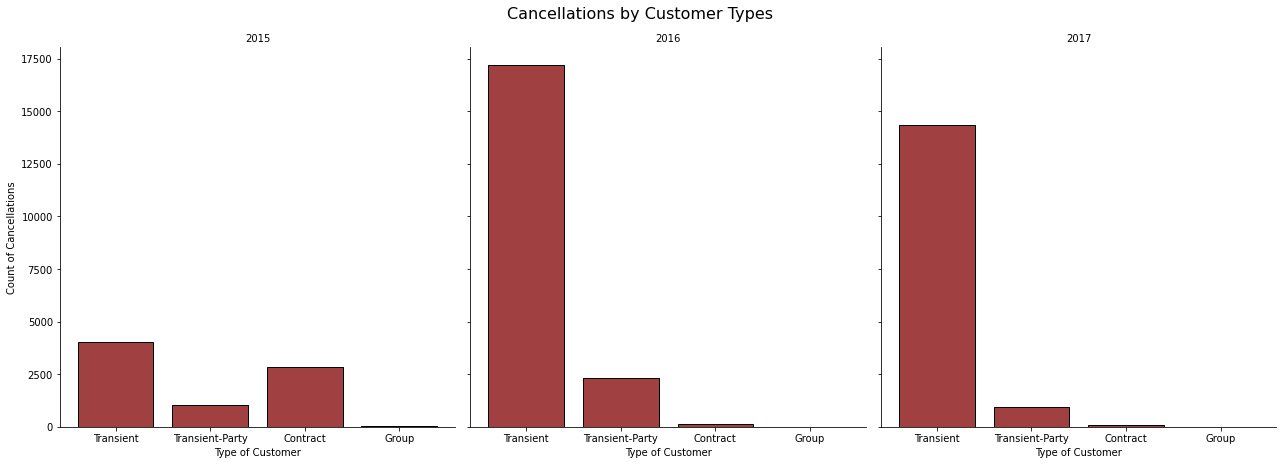

In [ ]:


g=sn.FacetGrid(customer_cancellations,col="arrival_date_year", height=4, aspect=1.4)
g=(g.map(sn.histplot,"customer_type", shrink=.8, color="maroon").set_axis_labels("Type of Customer", "Count of Cancellations").set_titles("{col_name}"))
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Cancellations by Customer Types", fontsize=16)
g.fig.set_figwidth(18)
g.fig.set_figheight(7)



In [ ]:
week_cancellations = data[["hotel","stays_in_week_nights","arrival_date_year","reservation_status"]]

week_cancellations=week_cancellations.loc[week_cancellations["reservation_status"]=='Canceled']

week_cancellations=week_cancellations.loc[week_cancellations["stays_in_week_nights"]>0]

week_cancellations

,hotel,stays_in_week_nights,arrival_date_year,reservation_status
8,Resort Hotel,3,2015,Canceled
9,Resort Hotel,3,2015,Canceled
10,Resort Hotel,4,2015,Canceled
27,Resort Hotel,5,2015,Canceled
32,Resort Hotel,8,2015,Canceled
...,...,...,...,...
107445,City Hotel,1,2017,Canceled
107980,City Hotel,1,2017,Canceled
107997,City Hotel,2,2017,Canceled
108000,City Hotel,2,2017,Canceled


In [ ]:
weekend_cancellations = data[["hotel","stays_in_weekend_nights","arrival_date_year","reservation_status"]]

weekend_cancellations=weekend_cancellations.loc[weekend_cancellations["reservation_status"]=='Canceled']

weekend_cancellations=weekend_cancellations.loc[weekend_cancellations["stays_in_weekend_nights"]>0]

weekend_cancellations

,hotel,stays_in_weekend_nights,arrival_date_year,reservation_status
27,Resort Hotel,2,2015,Canceled
32,Resort Hotel,2,2015,Canceled
34,Resort Hotel,1,2015,Canceled
35,Resort Hotel,1,2015,Canceled
38,Resort Hotel,1,2015,Canceled
...,...,...,...,...
100829,City Hotel,2,2017,Canceled
107445,City Hotel,2,2017,Canceled
107997,City Hotel,1,2017,Canceled
108000,City Hotel,1,2017,Canceled


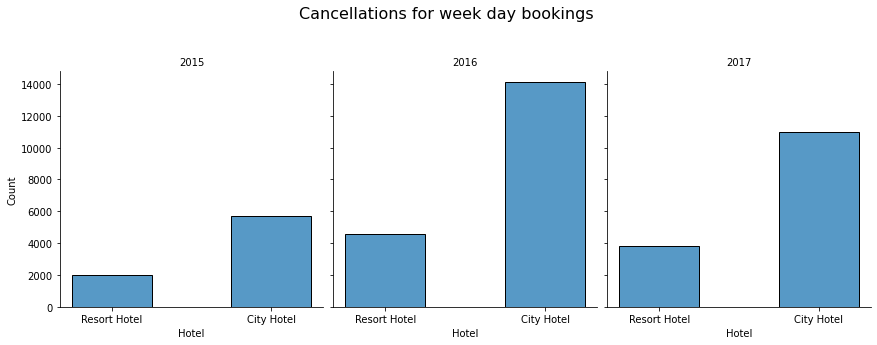

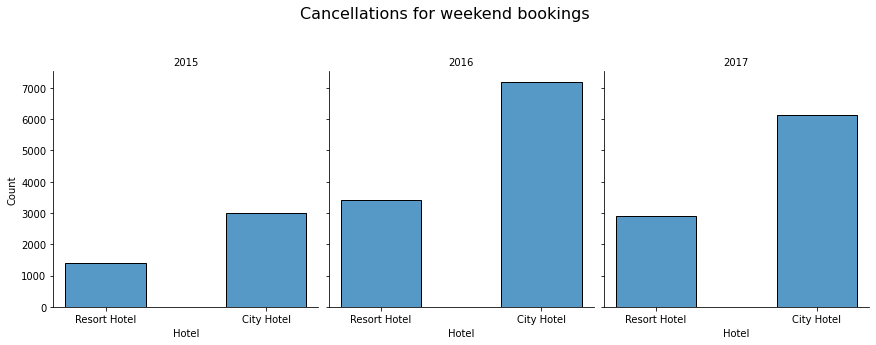

In [ ]:
g1=sn.FacetGrid(week_cancellations,col="arrival_date_year", height=4, aspect=1.4)
g1=(g1.map_dataframe(sn.histplot,"hotel", shrink=0.5).set_axis_labels("Hotel", "Count").set_titles("{col_name}"))
g1.fig.subplots_adjust(top=0.8)
g1.fig.suptitle("Cancellations for week day bookings", fontsize=16)
g1.fig.set_figwidth(12)
g1.fig.set_figheight(5)

g2=sn.FacetGrid(weekend_cancellations,col="arrival_date_year", height=4, aspect=1.4)
g2=(g2.map_dataframe(sn.histplot,"hotel", shrink=0.5).set_axis_labels("Hotel", "Count").set_titles("{col_name}"))
g2.fig.subplots_adjust(top=0.8)
g2.fig.suptitle("Cancellations for weekend bookings", fontsize=16)
g2.fig.set_figwidth(12)
g2.fig.set_figheight(5)

In [ ]:
changes_requested = data[["hotel","booking_changes","reservation_status"]]

changes_requested = changes_requested[changes_requested.reservation_status != 0]

changes_requested

,hotel,booking_changes,reservation_status
0,Resort Hotel,3,Check-Out
1,Resort Hotel,4,Check-Out
2,Resort Hotel,0,Check-Out
3,Resort Hotel,0,Check-Out
4,Resort Hotel,0,Check-Out
...,...,...,...
119385,City Hotel,0,Check-Out
119386,City Hotel,0,Check-Out
119387,City Hotel,0,Check-Out
119388,City Hotel,0,Check-Out


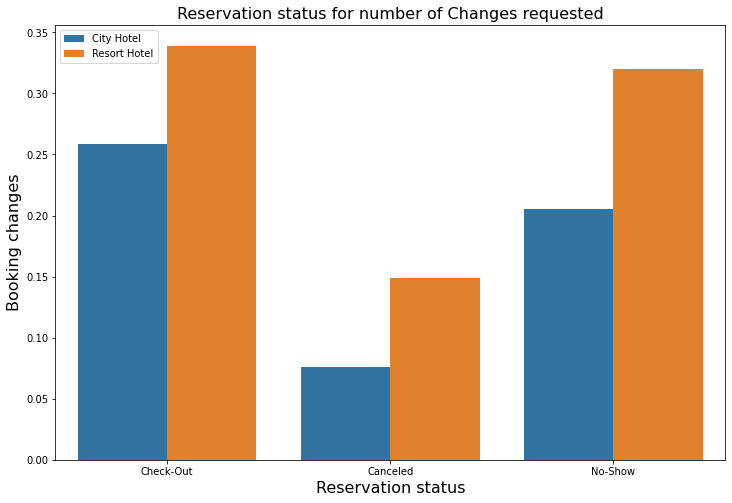

In [ ]:
#changes_requested["booking_changes"] = changes_requested["booking_changes"]

plt.figure(figsize=(12, 8))
sn.barplot(x="reservation_status",y="booking_changes" , 
          hue="hotel",hue_order = ["City Hotel", "Resort Hotel"],data=changes_requested, ci=None)
plt.title("Reservation status for number of Changes requested", fontsize=16)
plt.xlabel("Reservation status", fontsize=16)
plt.xticks(rotation=360)
plt.ylabel("Booking changes", fontsize=16)
plt.legend(loc="upper left")
plt.show()

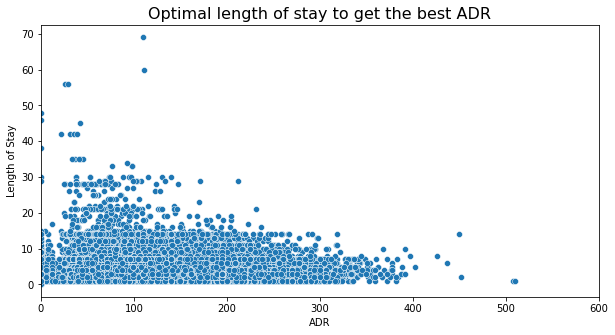

In [ ]:
plt.figure(figsize=(10,5))
sn.scatterplot(x=data.adr, y=data.Total_Stays)
plt.title("Optimal length of stay to get the best ADR", fontsize=16)
plt.xlabel("ADR",fontsize=10)
plt.ylabel("Length of Stay", fontsize=10)
plt.xlim(0,600)
plt.show()

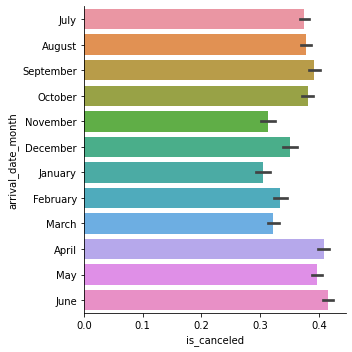

In [ ]:
sns.catplot(y='arrival_date_month',x='is_canceled',kind='bar',data=data)
plt.show()

In [ ]:
# ARIMA Model
dataResort = data[data['hotel'] == 'Resort Hotel']
dataCity = data[data['hotel'] == 'City Hotel']
NumberOfGuests_Resort = dataResort[['arrival_date', 'Total Guests']]
NumberOfGuests_ResortWeekly = dataResort['Total Guests'].groupby(dataResort['arrival_date']).sum()
NumberOfGuests_ResortWeekly = NumberOfGuests_ResortWeekly.resample('w').sum().to_frame()
NumberOfGuests_ResortWeekly.head()
NumberOfGuests_City = dataCity[['arrival_date', 'Total Guests']]
NumberOfGuests_CityWeekly = dataCity['Total Guests'].groupby(dataCity['arrival_date']).sum()
NumberOfGuests_CityWeekly = NumberOfGuests_CityWeekly.resample('w').sum().to_frame()
NumberOfGuests_CityWeekly.shape


(114, 1)

In [ ]:
CityWeeklyValues = NumberOfGuests_CityWeekly.values
result_city = adfuller(CityWeeklyValues)
print('ADF Statistic: %f' % result_city[0])
print('p-value: %f' % result_city[1])
print('Critical Values:')
for key, value in result_city[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.405358
p-value: 0.140230
Critical Values:
	1%: -3.491
	5%: -2.888
	10%: -2.581


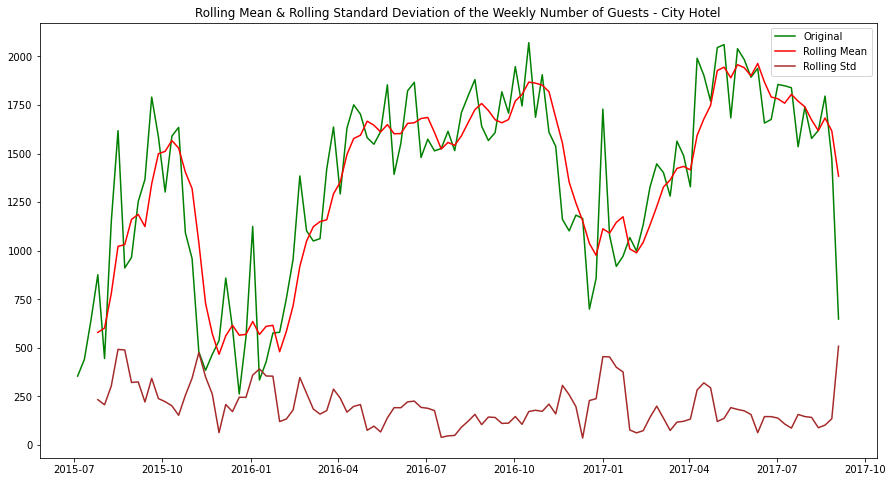

In [ ]:
# Rolling Mean & Rolling Standard Deviation of City Hotel
plt.figure(figsize=(15, 8))
rolling_mean = NumberOfGuests_CityWeekly.rolling(window=4).mean()
rolling_std = NumberOfGuests_CityWeekly.rolling(window=4).std()
plt.plot(NumberOfGuests_CityWeekly, color='green', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='brown', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Rolling Mean & Rolling Standard Deviation of the Weekly Number of Guests - City Hotel')
plt.show()


In [ ]:
trainCity = NumberOfGuests_CityWeekly[:90]
testCity = NumberOfGuests_CityWeekly[90:]

In [ ]:
stepwise_fit = auto_arima(trainCity['Total Guests'], start_p=1, start_q=1,
                          max_p=4, max_q=4, m=12,
                          start_P=0, seasonal=True,
                          d=1, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.13 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1135.191, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1122.415, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1134.172, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1120.748, Time=0.53 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.18 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1123.639, Time=0.39 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1118.934, Time=0.80 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1122.338, Time=0.28 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.66 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.65 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1120.912, Time=0.86 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=1120.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   90
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -554.467
Date:                            Mon, 13 Dec 2021   AIC                           1118.934
Time:                                    19:04:10   BIC                           1130.653
Sample:                                         0   HQIC                          1123.622
                                             - 90                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3231      0.114     -2.833      0.005      -0.547      -0.100
ar.L2         -0.2344      0.130     -1.805      0.071      -0.489       0.020
ar.S.L12      -0.7070      0.163     -4.347      0.000      -1.026      -0.388
ar.S.L24      -0.3508      0.158     -2.218      0.027      -0.661      -0.041
sigma2      9.865e+04   1.78e+04      5.531      0.000    6.37e+04    1.34e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.58
Prob(Q):                              0.96   Prob(JB):                         0.45
Heteroskedasticity (H):               0.65   Skew:                            -0.19
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
modelCity = ARIMA(trainCity['Total Guests'],
                  order=(2, 1, 0),
                  seasonal_order=(2, 1, 0, 12))

resultCity = modelCity.fit()

# Prediction of the Test data
predictionsCityTest = resultCity.predict(90, 113, typ='levels').rename("Predictions")
predictionsCityTrain = resultCity.predict(0, 89, typ='levels').rename("Predictions")


Text(0, 0.5, 'Number of Guests')

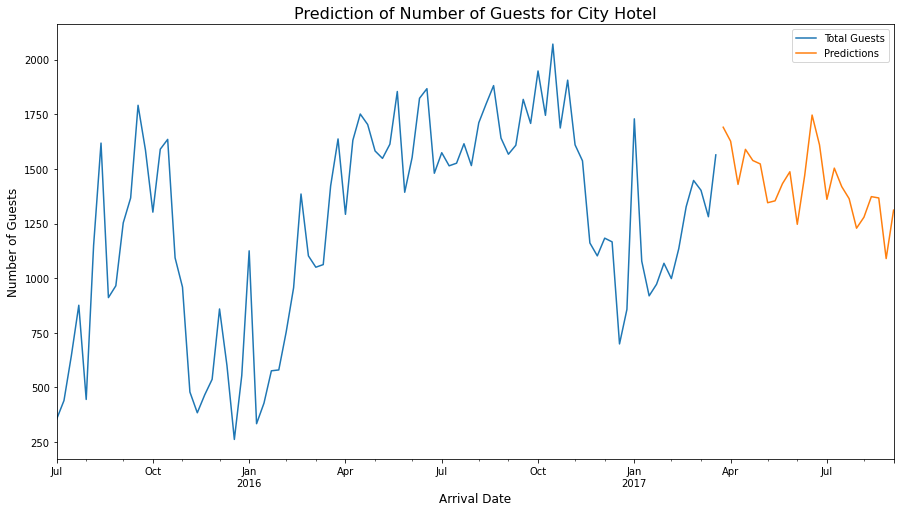

In [ ]:
plt.figure(figsize=(15, 8))
trainCity['Total Guests'].plot(legend=True)
predictionsCityTest.plot(legend=True)
plt.title('Prediction of Number of Guests for City Hotel', fontsize=16)
plt.xlabel('Arrival Date', fontsize=12)
plt.ylabel('Number of Guests', fontsize=12)

In [ ]:
import math
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error
MeanAbsPercentageErr = mean_absolute_percentage_error(testCity, predictionsCityTest)
RootMeanSquareErr=math.sqrt(mean_squared_error(testCity, predictionsCityTest))
MeanAbsPercentageErrTrain = mean_absolute_percentage_error(trainCity, predictionsCityTrain)
RootMeanSquareErrTrain=math.sqrt(mean_squared_error(trainCity, predictionsCityTrain))
print('Test MAPE City Hotel: %f' % MeanAbsPercentageErr)
print('Test RMSE City Hotel: %f' % RootMeanSquareErr)
print('Train MAPE City Hotel: %f' % MeanAbsPercentageErrTrain)
print('Train RMSE City Hotel: %f' % RootMeanSquareErrTrain)



Test MAPE City Hotel: 0.246411
Test RMSE City Hotel: 433.632436
Train MAPE City Hotel: 0.290665
Train RMSE City Hotel: 343.203017


In [ ]:
ResortWeeklyValues = NumberOfGuests_ResortWeekly.values
result_resort = adfuller(ResortWeeklyValues)
print('ADF Statistic: %f' % result_resort[0])
print('p-value: %f' % result_resort[1])
print('Critical Values:')
for key, value in result_resort[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.177045
p-value: 0.000720
Critical Values:
	1%: -3.490
	5%: -2.888
	10%: -2.581


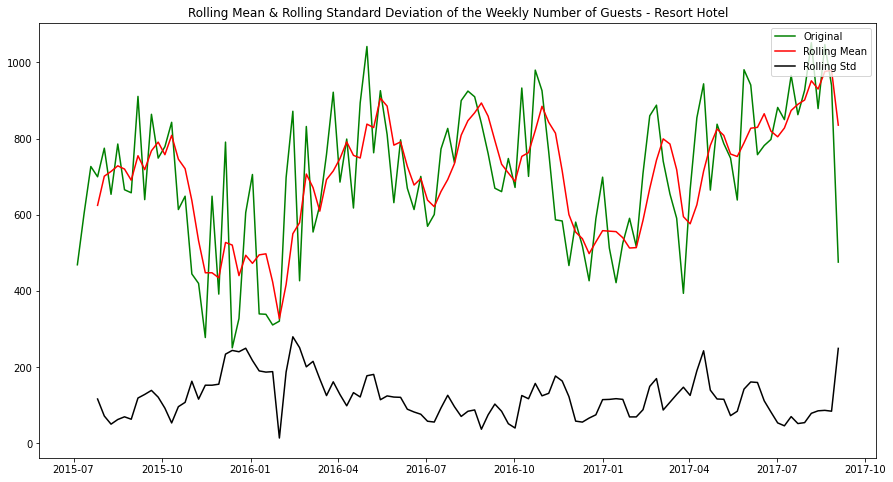

In [ ]:
plt.figure(figsize=(15, 8))
rolling_mean = NumberOfGuests_ResortWeekly.rolling(window=4).mean()
rolling_std = NumberOfGuests_ResortWeekly.rolling(window=4).std()
plt.plot(NumberOfGuests_ResortWeekly, color='green', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Rolling Mean & Rolling Standard Deviation of the Weekly Number of Guests - Resort Hotel')
plt.show()

In [ ]:
trainResort = NumberOfGuests_ResortWeekly[:90]
testResort = NumberOfGuests_ResortWeekly[90:]

In [ ]:
stepwise_fit = auto_arima(trainResort['Total Guests'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.37 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1089.489, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1057.808, Time=0.45 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1087.598, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1064.490, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1049.239, Time=1.47 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.50 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1074.224, Time=1.10 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1042.734, Time=1.89 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1050.409, Time=0.71 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.82 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=1044.1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   90
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -515.461
Date:                            Mon, 13 Dec 2021   AIC                           1040.922
Time:                                    19:04:45   BIC                           1052.706
Sample:                                         0   HQIC                          1045.639
                                             - 90                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3795      0.111      3.421      0.001       0.162       0.597
ar.L2          0.3245      0.103      3.162      0.002       0.123       0.526
ar.S.L12      -0.4828      0.132     -3.661      0.000      -0.741      -0.224
ar.S.L24      -0.4127      0.130     -3.183      0.001      -0.667      -0.159
sigma2      3.015e+04   6738.553      4.474      0.000    1.69e+04    4.34e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 1.19
Prob(Q):                              0.67   Prob(JB):                         0.55
Heteroskedasticity (H):               0.74   Skew:                            -0.04
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
modelResort = ARIMA(trainResort['Total Guests'],
                    order=(2, 0, 0),
                    seasonal_order=(2, 1, 0, 12))

resultResort = modelResort.fit()

# Prediction of the Test data
predictionsResortTest = resultResort.predict(90, 113, typ='levels').rename("Predictions")
predictionsResortTrain = resultResort.predict(0, 89, typ='levels').rename("Predictions")

Text(0, 0.5, 'Number of Guests')

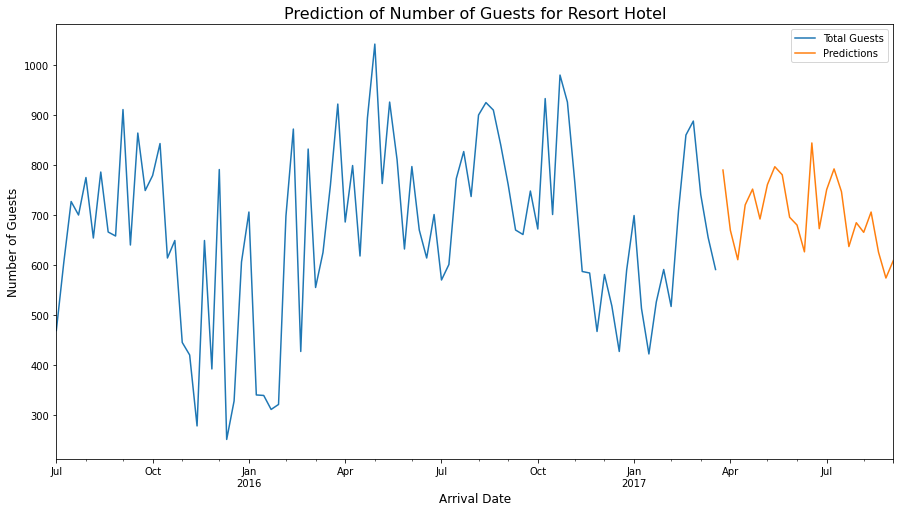

In [ ]:
plt.figure(figsize=(15, 8))
trainResort['Total Guests'].plot(legend=True)
predictionsResortTest.plot(legend=True)
plt.title('Prediction of Number of Guests for Resort Hotel', fontsize=16)
plt.xlabel('Arrival Date', fontsize=12)
plt.ylabel('Number of Guests', fontsize=12)

In [ ]:
MeanAbsPercentageErrResort_test = mean_absolute_percentage_error(testResort, predictionsResortTest)
MeanSquaredErr=math.sqrt(mean_squared_error(testResort, predictionsResortTest))
MeanAbsPercentageErrResort_train = mean_absolute_percentage_error(trainResort, predictionsResortTrain)
MeanSquaredErrTrain=math.sqrt(mean_squared_error(trainResort, predictionsResortTrain))
print('Test MAPE Resort Hotel: %f' % MeanAbsPercentageErrResort_test)
print('Test RMSE Resort Hotel: %f' % MeanSquaredErr)
print('Train MAPE Resort Hotel: %f' % MeanAbsPercentageErrResort_train)
print('Train RMSE Resort Hotel: %f' % MeanSquaredErrTrain)

Test MAPE Resort Hotel: 0.239072
Test RMSE Resort Hotel: 222.880506
Train MAPE Resort Hotel: 0.350690
Train RMSE Resort Hotel: 293.302752


In [ ]:
copy = data.copy()

In [ ]:
copy.fillna(0,inplace=True)

In [ ]:
copy['arrival_date'] = copy['arrival_date_year'].map(str) + '-' + month_number[0].map(str) + '-' \
                       + copy['arrival_date_day_of_month'].map(str)

In [ ]:
copy['children'] = copy['children'].astype(int)

In [ ]:
copy['arrival_date'] = pd.to_datetime(copy['arrival_date'])
copy['reservation_status_date'] = pd.to_datetime(copy['reservation_status_date'])

In [ ]:
copy['Total Guests'] = copy['adults'] + copy['children']
copy = copy[copy['Total Guests'] != 0]

In [ ]:
copy['Total_Stays'] = copy['stays_in_weekend_nights'] + copy['stays_in_week_nights']

In [ ]:
df = copy.copy()

In [ ]:
label = ['days_in_waiting_list', 'arrival_date_year', 'arrival_date_year', 'assigned_room_type', 'booking_changes',
               'reservation_status', 'country', 'days_in_waiting_list']
df.drop(labels=label,axis=1,inplace=True)

In [ ]:
cat_label=['hotel',
 'meal',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status_date']

In [ ]:
cat_df = df[cat_label]
cat_df.head()

,hotel,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,reservation_status_date
0,Resort Hotel,BB,Direct,Direct,C,No Deposit,Transient,2015-07-01
1,Resort Hotel,BB,Direct,Direct,C,No Deposit,Transient,2015-07-01
2,Resort Hotel,BB,Direct,Direct,A,No Deposit,Transient,2015-07-02
3,Resort Hotel,BB,Corporate,Corporate,A,No Deposit,Transient,2015-07-02
4,Resort Hotel,BB,Online TA,TA/TO,A,No Deposit,Transient,2015-07-03


In [ ]:
cat_df['reservation_status_date'] = pd.to_datetime(cat_df['reservation_status_date'])

cat_df['year'] = cat_df['reservation_status_date'].dt.year
cat_df['month'] = cat_df['reservation_status_date'].dt.month
cat_df['day'] = cat_df['reservation_status_date'].dt.day

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [ ]:
cat_df.drop(['reservation_status_date'] , axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
cat_df['hotel'] = cat_df['hotel'].astype('category').cat.codes

cat_df['meal'] = cat_df['meal'].astype('category').cat.codes

cat_df['market_segment'] = cat_df['market_segment'].astype('category').cat.codes

cat_df['distribution_channel'] = cat_df['distribution_channel'].astype('category').cat.codes

cat_df['reserved_room_type'] = cat_df['reserved_room_type'].astype('category').cat.codes

cat_df['deposit_type'] = cat_df['deposit_type'].astype('category').cat.codes

cat_df['customer_type'] = cat_df['customer_type'].astype('category').cat.codes

cat_df['year'] = cat_df['year'].astype('category').cat.codes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [ ]:
cat_df

,hotel,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,year,month,day
0,1,0,3,1,2,0,2,1,7,1
1,1,0,3,1,2,0,2,1,7,1
2,1,0,3,1,0,0,2,1,7,2
3,1,0,2,0,0,0,2,1,7,2
4,1,0,6,3,0,0,2,1,7,3
...,...,...,...,...,...,...,...,...,...,...
119385,0,0,5,3,0,0,2,3,9,6
119386,0,0,6,3,4,0,2,3,9,7
119387,0,0,6,3,3,0,2,3,9,7
119388,0,0,6,3,0,0,2,3,9,7


In [ ]:
num_df = df.drop(columns = cat_label, axis = 1)
num_df.drop('is_canceled', axis = 1, inplace = True)
num_df

,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,adr,required_car_parking_spaces,total_of_special_requests,arrival_date,Total Guests,Total_Stays,adr_pp
0,342,July,27,1,0,0,2,0,0,0,0,0,0.0,0.0,0.00,0,0,2015-07-01,2,0,0.000000
1,737,July,27,1,0,0,2,0,0,0,0,0,0.0,0.0,0.00,0,0,2015-07-01,2,0,0.000000
2,7,July,27,1,0,1,1,0,0,0,0,0,0.0,0.0,75.00,0,0,2015-07-01,1,1,75.000000
3,13,July,27,1,0,1,1,0,0,0,0,0,304.0,0.0,75.00,0,0,2015-07-01,1,1,75.000000
4,14,July,27,1,0,2,2,0,0,0,0,0,240.0,0.0,98.00,0,1,2015-07-01,2,2,49.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,23,August,35,30,2,5,2,0,0,0,0,0,394.0,0.0,96.14,0,0,2017-08-30,2,7,48.070000
119386,102,August,35,31,2,5,3,0,0,0,0,0,9.0,0.0,225.43,0,2,2017-08-31,3,7,75.143333
119387,34,August,35,31,2,5,2,0,0,0,0,0,9.0,0.0,157.71,0,4,2017-08-31,2,7,78.855000
119388,109,August,35,31,2,5,2,0,0,0,0,0,89.0,0.0,104.40,0,0,2017-08-31,2,7,52.200000


In [ ]:
num_df.drop(['Total_Stays','adr_pp','arrival_date','company','Total Guests'],axis=1,inplace=True)

In [ ]:
num_df

,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,adr,required_car_parking_spaces,total_of_special_requests
0,342,July,27,1,0,0,2,0,0,0,0,0,0.0,0.00,0,0
1,737,July,27,1,0,0,2,0,0,0,0,0,0.0,0.00,0,0
2,7,July,27,1,0,1,1,0,0,0,0,0,0.0,75.00,0,0
3,13,July,27,1,0,1,1,0,0,0,0,0,304.0,75.00,0,0
4,14,July,27,1,0,2,2,0,0,0,0,0,240.0,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,23,August,35,30,2,5,2,0,0,0,0,0,394.0,96.14,0,0
119386,102,August,35,31,2,5,3,0,0,0,0,0,9.0,225.43,0,2
119387,34,August,35,31,2,5,2,0,0,0,0,0,9.0,157.71,0,4
119388,109,August,35,31,2,5,2,0,0,0,0,0,89.0,104.40,0,0


In [ ]:
num_df['lead_time'] = np.log(num_df['lead_time'] + 1)
num_df['arrival_date_week_number'] = np.log(num_df['arrival_date_week_number'] + 1)
num_df['arrival_date_day_of_month'] = np.log(num_df['arrival_date_day_of_month'] + 1)
num_df['agent'] = np.log(num_df['agent'] + 1)
num_df['adr'] = np.log(num_df['adr'] + 1)


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning:

invalid value encountered in log



In [ ]:
num_df['arrival_date_month'] = num_df['arrival_date_month'].astype('category').cat.codes

In [ ]:
num_df['adr'] = num_df['adr'].fillna(value = num_df['adr'].mean())

In [ ]:
X = pd.concat([cat_df, num_df], axis = 1)
y = df['is_canceled']

In [ ]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.40,random_state=0)

In [ ]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)

print("Train------------------->")
y_pred_lr_train = lr.predict(X_train)
print(accuracy_score(y_pred_lr_train,y_train))
print(f1_score(y_train,y_pred_lr_train))
print(recall_score(y_train,y_pred_lr_train))
print(roc_auc_score(y_train,y_pred_lr_train))
print("Test-------------------->")
y_pred_lr = lr.predict(X_test)
print(accuracy_score(y_pred_lr,y_test))
print(f1_score(y_test,y_pred_lr))
print(recall_score(y_test,y_pred_lr))
print(roc_auc_score(y_test,y_pred_lr))

Train------------------->
0.8146967536280514
0.6967464421360912
0.5756086496295176
0.765307985461695
Test-------------------->
0.8116139585605234
0.6946738724040652
0.5758156308108413
0.7636067832378688


In [ ]:
# dt = RandomForestClassifier()
# dt.fit(X_train, y_train)

# print("Train------------------->")
# y_pred_dt_train = dt.predict(X_train)
# print(accuracy_score(y_pred_dt_train,y_train))
# print(f1_score(y_pred_dt_train,y_train))
# print(recall_score(y_pred_dt_train,y_train))
# print(roc_auc_score(y_pred_dt_train,y_train))
# print("Test-------------------->")
# y_pred_dt = dt.predict(X_test)
# print(accuracy_score(y_test,y_pred_dt))
# print(f1_score(y_test,y_pred_dt))
# print(recall_score(y_test,y_pred_dt))
# print(roc_auc_score(y_test,y_pred_dt))

In [ ]:
 xgb = XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc",n_estimators=100, subsample = 0.8,colsample_bytree= 0.8,learning_rate= 0.09,g_rate= 0.09,max_depth= 5)
xgb.fit(X_train, y_train)

print("Train------------------->")
y_pred_xgb_train = xgb.predict(X_train)
print(accuracy_score(y_train,y_pred_xgb_train))
print(f1_score(y_train,y_pred_xgb_train))
print(recall_score(y_train,y_pred_xgb_train))
print(roc_auc_score(y_train,y_pred_xgb_train))
print("Test-------------------->")
y_pred_xgb = xgb.predict(X_test)
print(accuracy_score(y_test,y_pred_xgb))
print(f1_score(y_test,y_pred_xgb))
print(recall_score(y_test,y_pred_xgb))
print(roc_auc_score(y_test,y_pred_xgb))

Train------------------->
0.9586723708861113
0.9408918216356729
0.8894223499168304
0.9443672960038072
Test-------------------->
0.9573861253250566
0.939401169032566
0.8874739392573393
0.9431524087174228


In [ ]:
sc = SVC()
sc.fit(X_train, y_train)

print("Train------------------->")
y_pred_sc_train = sc.predict(X_train)
print(accuracy_score(y_train,y_pred_sc_train))
print(f1_score(y_train,y_pred_sc_train))
print(recall_score(y_train,y_pred_sc_train))
print(roc_auc_score(y_train,y_pred_sc_train))
print("Test-------------------->")
y_pred_sc = sc.predict(X_test)
print(accuracy_score(y_test,y_pred_sc))
print(f1_score(y_test,y_pred_sc))
print(recall_score(y_test,y_pred_sc))
print(roc_auc_score(y_test,y_pred_sc))

Train------------------->
0.8553812599614127
0.7616370172366116
0.624754271888704
0.8077403164918959
Test-------------------->
0.8561362301820317
0.7652774926435366
0.6301346706485603
0.810123620189163


In [ ]:
lgb = LGBMClassifier(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)

In [ ]:
lgb.fit(X_train, y_train)

print("Train------------------->")
y_pred_lgb_train = lgb.predict(X_train)
print(accuracy_score(y_train,y_pred_lgb_train))
print(f1_score(y_train,y_pred_lgb_train))
print(recall_score(y_train,y_pred_lgb_train))
print(roc_auc_score(y_train,y_pred_lgb_train))
print("Test-------------------->")
y_pred_lgb = lgb.predict(X_test)
print(accuracy_score(y_test,y_pred_lgb))
print(f1_score(y_test,y_pred_lgb))
print(recall_score(y_test,y_pred_lgb))
print(roc_auc_score(y_test,y_pred_lgb))

Train------------------->
0.8589324161843246
0.7687159033603815
0.6339029184938757
0.8124477542285236
Test-------------------->
0.8583591980538545
0.7696610053884455
0.6358257733701471
0.8130526802515632


#Likelihood prediction of disproportinately high number of special requests.

In [ ]:
data.customer_type.value_counts()

In [ ]:
data.head()

In [ ]:
data.dtypes

In [ ]:
data_cat = data.select_dtypes("object")
data_num = data.select_dtypes("number")

In [ ]:
data_cat.dtypes

In [ ]:
data_cat.head()

In [ ]:
cat = ['hotel',	'arrival_date_month',	'meal',	'country',	'market_segment',	'distribution_channel',	'reserved_room_type',	'assigned_room_type',	'deposit_type',	'customer_type',	
       'reservation_status']

In [ ]:
data_cat=data_cat.astype('category')

In [ ]:
data_cat.head()

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data_cat = data_cat.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')
#OneHotEncoder().fit_transform(data_cat)

In [ ]:

data_new = pd.concat([data_num, data_cat], axis=1)

In [ ]:
data_new.head()

## Data Splitting and Data Scaling

In [ ]:
# printing feature importances
from sklearn.model_selection import train_test_split
X = data_new.drop(['total_of_special_requests'],axis=1)  #independent columns
y = data_new['total_of_special_requests']   #target column i.e conversion

# split the data into 
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.40, random_state=1984, stratify = y)

In [ ]:
y_train = y_train.values.reshape(len(y_train), 1)
y_test = y_test.values.reshape(len(y_test), 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# define min max scaler
scaler = MinMaxScaler()
# transform data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.fit_transform(y_test)


## Random Forest with Feature Scaling

In [ ]:
from sklearn.ensemble import RandomForestRegressor
  
 # create regressor object
rfr = RandomForestRegressor(n_estimators = 100, random_state = 0, max_depth=5)
  
# fit the regressor with x and y data
rfr.fit(X_train_scaled, y_train_scaled)

In [ ]:
from sklearn import metrics
y_pred = rfr.predict(X_test_scaled)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_scaled, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_scaled, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_scaled, y_pred)))

## Feature Scaling

In [ ]:
feature_scores = pd.Series(rfr.feature_importances_, index=X.columns).sort_values(ascending=False)

top10_feature_scores=pd.Series(feature_scores.nlargest(n=10))

In [ ]:
f, ax = plt.subplots(figsize=(30, 24))
ax = sn.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

In [ ]:
print(top10_feature_scores)

In [ ]:
selected_features = ['market_segment', 'reservation_status', 'is_canceled', 'lead_time', 'adr', 'Total Guests', 'arrival_date_year', 
                     'arrival_date_week_number', 'previous_bookings_not_canceled', 'customer_type']

In [ ]:
X_train_select = X_train[selected_features]
X_test_select = X_test[selected_features]

## Random Forest with Scaled and Selected Features

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# define min max scaler
scaler = MinMaxScaler()
# transform data
X_train_SS = scaler.fit_transform(X_train_select)
X_test_SS = scaler.fit_transform(X_test_select)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
  
 # create regressor object
rfr = RandomForestRegressor(n_estimators = 100, random_state = 0, max_depth=5)
  
# fit the regressor with x and y data
rfr.fit(X_train_scaled, y_train_scaled)

In [ ]:
y_pred_train = rfr.predict(X_train_scaled)

In [ ]:
print('Mean Absolute Error for Train Data:', metrics.mean_absolute_error(y_train_scaled, y_pred_train))
print('Mean Squared Error for Train Data:', metrics.mean_squared_error(y_train_scaled, y_pred_train))
print('Root Mean Squared Error for Train Data:', np.sqrt(metrics.mean_squared_error(y_train_scaled, y_pred_train)))

In [ ]:
y_pred_test = rfr.predict(X_test_scaled)

In [ ]:
print('Mean Absolute Error for Test Data:', metrics.mean_absolute_error(y_test_scaled, y_pred))
print('Mean Squared Error for Test Data:', metrics.mean_squared_error(y_test_scaled, y_pred))
print('Root Mean Squared Error for Test Data:', np.sqrt(metrics.mean_squared_error(y_test_scaled, y_pred)))

## XGBoost Algorithm

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}
xgbr = xgb.XGBRegressor(seed = 20)
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)
clf.fit(X_train_SS, y_train_scaled)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

In [ ]:
y_pred_tr = clf.predict(X_train_SS)

In [ ]:
from sklearn import metrics

print('Mean Absolute Error for Train Data:', metrics.mean_absolute_error(y_train_scaled, y_pred_tr))
print('Mean Squared Error for Train Data:', metrics.mean_squared_error(y_train_scaled, y_pred_tr))
print('Root Mean Squared Error for Train Data:', np.sqrt(metrics.mean_squared_error(y_train_scaled, y_pred_tr)))

In [ ]:
y_pred = clf.predict(X_test_SS)

In [ ]:
from sklearn import metrics

print('Mean Absolute Error for test data:', metrics.mean_absolute_error(y_test_scaled, y_pred))
print('Mean Squared Error for test data:', metrics.mean_squared_error(y_test_scaled, y_pred))
print('Root Mean Squared Error for test data:', np.sqrt(metrics.mean_squared_error(y_test_scaled, y_pred)))

In [ ]:
# printing feature importances
from sklearn.model_selection import train_test_split
X_g = data.drop(['total_of_special_requests'],axis=1)  #independent columns
y_g = data['total_of_special_requests']   #target column i.e conversion

# split the data into 
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(
X_g, y_g, test_size=0.40, random_state=1984, stratify = y)

In [ ]:
pred_df = pd.DataFrame(X_test_g)

In [ ]:
pred_df['pred'] = y_pred

In [ ]:
# eda_df = pred_df[pred_df['pred'] > 0.1]

In [ ]:
e = eda_df.groupby(['country']).sum('pred')
e.nlargest(10, ['pred'])

In [ ]:
selected_rows = ['PRT', 'GBR', 'FRA', 'ESP', 'DEU']

In [ ]:
eda_df = eda_df.loc[eda_df['country'].isin(selected_rows)]

In [ ]:
eda_df = eda_df[eda_df['pred'] > 0.3]

In [ ]:
eda_df.head()

In [ ]:
import datetime
import calendar

# date_rng = pd.date_range('2015-01-01', '2019-01-01', freq='1D')
# val = np.random.randint(5,50,(1462,))

# MojaBaza = pd.DataFrame({'date':pd.to_datetime(date_rng), 'value':val})

# MojaBaza['Month'] = MojaBaza['date'].dt.month
ordered_months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
eda_df["arrival_date_month"] = pd.Categorical(eda_df["arrival_date_month"], categories=ordered_months, ordered=True)

# temp = temp.reindex(index=months)
# wykres = temp.plot(kind='bar', figsize=(8,8), title="Amount of the crimes in Boston during the months in years 2015-2018 ")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_plot = pd.DataFrame({'arrival_date_month': eda_df['arrival_date_month'], 'country': eda_df['country'], 'pred': eda_df['pred']})

# Turn long format into a wide format
df_wide = data_plot.pivot_table( index='country', columns='arrival_date_month', values='pred')

# plot it
sns.heatmap(df_wide, cmap="YlGnBu")

sns.set(rc = {'figure.figsize':(15,10)})

plt.show()